In [12]:
import os


labels = []
all_files = []
path = 'D:/vibration-3classes'
labels_list = os.listdir(path)
print(labels_list)        
for i in labels_list:
    wavs_path = os.path.join(path,i)
    second_dirs = os.listdir(wavs_path)
    for csv in second_dirs:
        labels.append(i)
        csvFilePath = wavs_path+'/'+csv
        all_files.append(csvFilePath)
print(labels)
print(len(all_files))

['Cage', 'Inner race', 'Outer race']
['Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'Cage', 'C

In [13]:
import torch
from torch.utils.data import Dataset

from vmdpy import VMD
import numpy as np


import pandas as pd
from sklearn.preprocessing import OneHotEncoder

import os

path = 'D:/vibration'
class MyDataset(Dataset):
    def __init__(self):
        labels = []
        path = 'D:/vibration-3classes'
        labels_list = os.listdir(path)
        for i in labels_list:
            wavs_path = os.path.join(path, i)
            second_dirs = os.listdir(wavs_path)
            for csv in second_dirs:
                labels.append(i)
        self.label = np.array(labels)
        # 创建 OneHotEncoder 对象
        self.encoder = OneHotEncoder(sparse_output=False)
        # 对标签进行独热编码
        encoded_labels = self.encoder.fit_transform([[label] for label in self.label])
        # 将独热编码结果保存为 Tensor
        self.encoded_labels_tensor = torch.tensor(encoded_labels, dtype=torch.float32)

    def __len__(self):
        return len(self.encoded_labels_tensor)

    def __getitem__(self,index):
        Fs=1024 # 采样频率
        N=1024 # 采样点数
        t=np.arange(1,N+1)/N
        fre_axis=np.linspace(0,Fs/2,int(N/2))
        label = self.encoded_labels_tensor[index]
        alpha=1500
        tau=0 # tau 噪声容限，即允许重构后的信号与原始信号有差别。
        K=3 # K 分解模态（IMF）个数
        DC=0 # DC 若为0则让第一个IMF为直流分量/趋势向量
        init=1 # init 指每个IMF的中心频率进行初始化。当初始化为1时，进行均匀初始化。
        tol=1e-7 # 控制误差大小常量，决定精度与迭代次数
        all_files = []
        path = 'D:/vibration-3classes'
        labels_list = os.listdir(path)
        for i in labels_list:
            wavs_path = os.path.join(path,i)
            second_dirs = os.listdir(wavs_path)
            for csv in second_dirs:
                csvFilePath = wavs_path+'/'+csv
                all_files.append(csvFilePath)
        csvpath = all_files[index]
        data = pd.read_csv(csvpath)
        signal = data['0']
        signal = np.array(signal)
        u, u_hat, omega = VMD(signal, alpha, tau, K, DC, init, tol) # 输出U是各个IMF分量，u_hat是各IMF的频谱，omega为各IMF的中心频率
        # 返回加载和预处理后的数据
        return torch.as_tensor(u,dtype=torch.float32), torch.as_tensor(label,dtype=torch.float)



In [14]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

In [15]:
dataset1 = MyDataset()
total_size = len(dataset1)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
print(total_size,train_size,val_size,test_size)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset1, [train_size, val_size, test_size])


21000 14699 3150 3151


In [16]:
data,label = dataset1[3714]
print(data)
print(data.shape)
print(label)

tensor([[ 0.1445,  0.1360,  0.1192,  ...,  0.2851,  0.3013,  0.3064],
        [-0.0951, -0.0077,  0.0871,  ...,  0.0060, -0.0220, -0.0410],
        [-0.0710,  0.1301, -0.0299,  ..., -0.0969,  0.1125, -0.0499]])
torch.Size([3, 1024])
tensor([1., 0., 0.])


In [17]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class TransformerClassifier(nn.Module):
    def __init__(self,input_dim,hidden_dim,num_classes,num_layers,linear_dim,num_heads, dropout):
        super(TransformerClassifier, self).__init__()
        self.linear = nn.Linear(input_dim,hidden_dim)
        self.hidden_dim = hidden_dim
        self.position_encoding = PositionalEncoding(hidden_dim)
        self.transformer_encoder = TransformerEncoder(hidden_dim, num_layers, num_heads, dropout)
        self.MLPclassifier = MLPClassifier(hidden_dim,linear_dim,num_classes)

    def forward(self, x):
        x = self.linear(x)
        encoded = self.position_encoding(x)
        transformed = self.transformer_encoder(encoded)
        output = self.MLPclassifier(transformed)
        return output


class PositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, max_length=3):
        super(PositionalEncoding, self).__init__()

        position_encoding = torch.zeros(max_length, hidden_dim)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_dim, 2).float() * (-math.log(10000.0) / hidden_dim))

        position_encoding[:, 0::2] = torch.sin(position * div_term)
        position_encoding[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('position_encoding', position_encoding.unsqueeze(0))

    def forward(self, x):
        '''
        x: [seq_len, batch_size, d_model]
        '''
        x = x + self.position_encoding[:x.size(0), :]
        return x


class TransformerEncoder(nn.Module):
    def __init__(self, hidden_dim, num_layers, num_heads, dropout):
        super(TransformerEncoder, self).__init__()

        self.layers = nn.ModuleList([
            TransformerEncoderLayer(hidden_dim, num_heads, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class TransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads, dropout):
        super(TransformerEncoderLayer, self).__init__()

        self.multihead_attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attended = self.multihead_attention(x, x, x)[0]
        x = x + self.dropout(attended)
        x = self.layer_norm1(x)

        fed_forward = self.feed_forward(x)
        x = x + self.dropout(fed_forward)
        x = self.layer_norm2(x)

        return x

class MLPClassifier(nn.Module):
    def __init__(self,hidden_dim,linear_dim,num_classes):
        super(MLPClassifier, self).__init__()
        
        self.var = num_classes * hidden_dim
        self.linear_1 = nn.Linear(self.var,linear_dim)
        self.linear_2 = nn.Linear(linear_dim,num_classes)
        
        

    
    def forward(self,x):
        x = x.reshape(-1,self.var)
        x = self.linear_1(x)
        x = F.relu(x)
        x = self.linear_2(x)
        x = F.softmax(x,dim=1)
        
        return x


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 创建模型实例
model = TransformerClassifier(input_dim=1024,
                              hidden_dim=1024,
                              linear_dim=512,
                              num_classes=3,
                              num_layers=1,
                              num_heads=4,
                              dropout=0.1
                              ).cuda()
for param in model.parameters():
    print(type(param), param.size())
    
num_params = sum([param.nelement() for param in model.parameters()])
print(num_params)

<class 'torch.nn.parameter.Parameter'> torch.Size([1024, 1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([3072, 1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([3072])
<class 'torch.nn.parameter.Parameter'> torch.Size([1024, 1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([2048, 1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([2048])
<class 'torch.nn.parameter.Parameter'> torch.Size([1024, 2048])
<class 'torch.nn.parameter.Parameter'> torch.Size([1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([1024])
<class 'torch.nn.parameter.Parameter'> torch.Size([512, 3072])
<class 'torch.nn.parameter.Parameter'> torch.Size([512])
<class 'torch.nn.parameter.Parameter'>

In [20]:
print(model)

TransformerClassifier(
  (linear): Linear(in_features=1024, out_features=1024, bias=True)
  (position_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (multihead_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (feed_forward): Sequential(
          (0): Linear(in_features=1024, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=1024, bias=True)
        )
        (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (layer_norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (MLPclassifier): MLPClassifier(
    (linear_1): Linear(in_features=3072, out_features=512, bias=True)
    (linear_2): Linear(in_features=512, out_features=3, bias=

In [21]:
print(torch.cuda.is_available())
print(torch.version.cuda)

model = model.to('cuda')

for name, param in model.named_parameters():
    print(f"Parameter: {name}, Device: {param.device}")


True
12.1
Parameter: linear.weight, Device: cuda:0
Parameter: linear.bias, Device: cuda:0
Parameter: transformer_encoder.layers.0.multihead_attention.in_proj_weight, Device: cuda:0
Parameter: transformer_encoder.layers.0.multihead_attention.in_proj_bias, Device: cuda:0
Parameter: transformer_encoder.layers.0.multihead_attention.out_proj.weight, Device: cuda:0
Parameter: transformer_encoder.layers.0.multihead_attention.out_proj.bias, Device: cuda:0
Parameter: transformer_encoder.layers.0.feed_forward.0.weight, Device: cuda:0
Parameter: transformer_encoder.layers.0.feed_forward.0.bias, Device: cuda:0
Parameter: transformer_encoder.layers.0.feed_forward.2.weight, Device: cuda:0
Parameter: transformer_encoder.layers.0.feed_forward.2.bias, Device: cuda:0
Parameter: transformer_encoder.layers.0.layer_norm1.weight, Device: cuda:0
Parameter: transformer_encoder.layers.0.layer_norm1.bias, Device: cuda:0
Parameter: transformer_encoder.layers.0.layer_norm2.weight, Device: cuda:0
Parameter: transf

In [22]:
optimizer = optim.Adam(model.parameters(), lr=0.00005)

num_epochs = 20
train_losses = []
train_accs = []
val_losses = []
val_accs = []



for epoch in range(num_epochs):
    model.train()

    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in tqdm(train_dataloader):
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        
        for i in range(labels.size(0)):
            onehotpredicted = torch.zeros(3)
            index = predicted[i]
            onehotpredicted[index]=1.0
            onehotpredicted = onehotpredicted.to('cuda')
            if torch.equal(onehotpredicted,labels[i]):
                train_correct += 1

    train_loss /= len(train_dataloader)
    train_acc = train_correct / train_total

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.cuda(), labels.cuda()
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)

            for i in range(labels.size(0)):
                onehotpredicted = torch.zeros(3)
                index = predicted[i]
                onehotpredicted[index]=1.0
                onehotpredicted = onehotpredicted.to('cuda')
                if torch.equal(onehotpredicted,labels[i]):
                    correct += 1

    val_loss /= len(val_dataloader)
    val_acc = correct / total

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

100%|██████████| 460/460 [05:44<00:00,  1.34it/s]


Epoch 1/20, Train Loss: 0.9301, Train Acc: 0.6011, Val Loss: 0.8375, Val Acc: 0.6873


100%|██████████| 460/460 [04:03<00:00,  1.89it/s]


Epoch 2/20, Train Loss: 0.7412, Train Acc: 0.8169, Val Loss: 0.6776, Val Acc: 0.8784


100%|██████████| 460/460 [04:59<00:00,  1.53it/s]


Epoch 3/20, Train Loss: 0.6552, Train Acc: 0.9011, Val Loss: 0.6648, Val Acc: 0.8876


100%|██████████| 460/460 [04:04<00:00,  1.88it/s]


Epoch 4/20, Train Loss: 0.6444, Train Acc: 0.9075, Val Loss: 0.6574, Val Acc: 0.8930


100%|██████████| 460/460 [03:53<00:00,  1.97it/s]


Epoch 5/20, Train Loss: 0.6393, Train Acc: 0.9127, Val Loss: 0.6512, Val Acc: 0.9025


100%|██████████| 460/460 [03:52<00:00,  1.98it/s]


Epoch 6/20, Train Loss: 0.6318, Train Acc: 0.9195, Val Loss: 0.6898, Val Acc: 0.8587


100%|██████████| 460/460 [03:57<00:00,  1.94it/s]


Epoch 7/20, Train Loss: 0.6252, Train Acc: 0.9256, Val Loss: 0.6357, Val Acc: 0.9137


100%|██████████| 460/460 [04:52<00:00,  1.58it/s]


Epoch 8/20, Train Loss: 0.6094, Train Acc: 0.9422, Val Loss: 0.6081, Val Acc: 0.9483


100%|██████████| 460/460 [07:25<00:00,  1.03it/s]


Epoch 9/20, Train Loss: 0.5932, Train Acc: 0.9592, Val Loss: 0.6050, Val Acc: 0.9457


100%|██████████| 460/460 [07:24<00:00,  1.04it/s]


Epoch 10/20, Train Loss: 0.5931, Train Acc: 0.9586, Val Loss: 0.6044, Val Acc: 0.9476


100%|██████████| 460/460 [04:37<00:00,  1.65it/s]


Epoch 11/20, Train Loss: 0.5835, Train Acc: 0.9680, Val Loss: 0.6098, Val Acc: 0.9400


100%|██████████| 460/460 [03:57<00:00,  1.94it/s]


Epoch 12/20, Train Loss: 0.5794, Train Acc: 0.9723, Val Loss: 0.5918, Val Acc: 0.9600


100%|██████████| 460/460 [03:57<00:00,  1.93it/s]


Epoch 13/20, Train Loss: 0.5748, Train Acc: 0.9773, Val Loss: 0.5927, Val Acc: 0.9571


100%|██████████| 460/460 [04:06<00:00,  1.87it/s]


Epoch 14/20, Train Loss: 0.5730, Train Acc: 0.9789, Val Loss: 0.5904, Val Acc: 0.9597


100%|██████████| 460/460 [04:05<00:00,  1.87it/s]


Epoch 15/20, Train Loss: 0.5727, Train Acc: 0.9790, Val Loss: 0.5985, Val Acc: 0.9549


100%|██████████| 460/460 [03:56<00:00,  1.94it/s]


Epoch 16/20, Train Loss: 0.5833, Train Acc: 0.9688, Val Loss: 0.6140, Val Acc: 0.9343


100%|██████████| 460/460 [03:55<00:00,  1.95it/s]


Epoch 17/20, Train Loss: 0.5911, Train Acc: 0.9603, Val Loss: 0.6065, Val Acc: 0.9435


100%|██████████| 460/460 [04:45<00:00,  1.61it/s]


Epoch 18/20, Train Loss: 0.5825, Train Acc: 0.9688, Val Loss: 0.6019, Val Acc: 0.9489


100%|██████████| 460/460 [04:07<00:00,  1.86it/s]


Epoch 19/20, Train Loss: 0.5729, Train Acc: 0.9784, Val Loss: 0.5858, Val Acc: 0.9651


100%|██████████| 460/460 [07:28<00:00,  1.02it/s]


Epoch 20/20, Train Loss: 0.5661, Train Acc: 0.9854, Val Loss: 0.5817, Val Acc: 0.9686


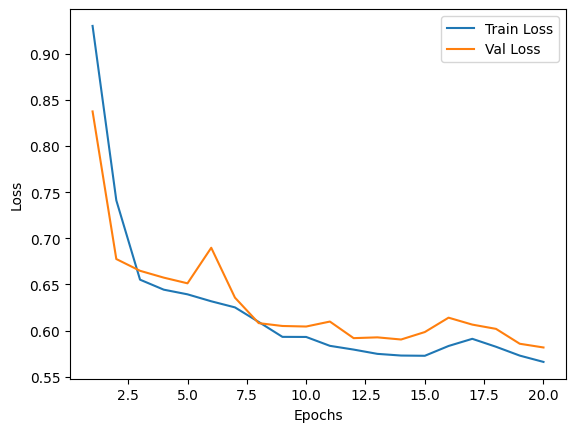

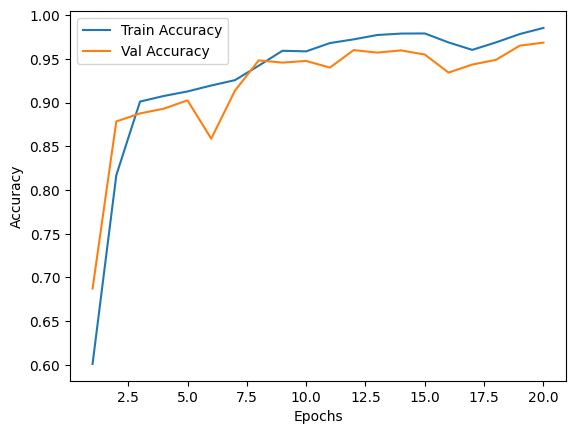

In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs+1), train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accs, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
torch.save(train_losses,'C:/Users/dell/Desktop/工作文件/论文图/3imfs_trainlosses_1.pt')
torch.save(train_accs,'C:/Users/dell/Desktop/工作文件/论文图/3imfs_trainaccs_1.pt')

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 绘制混淆矩阵的函数
def plot_confusion_matrix(cm, labels_name, title="Confusion Matrix",  is_norm=True,  colorbar=True, cmap=plt.cm.Blues):
    if is_norm==True:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2)  # 横轴归一化并保留2位小数

    plt.imshow(cm, interpolation='nearest', cmap=cmap)  # 在特定的窗口上显示图像
    for i in range(len(cm)):
        for j in range(len(cm)):
            plt.annotate(cm[j, i], xy=(i, j), horizontalalignment='center', verticalalignment='center') # 默认所有值均为黑色
            # plt.annotate(cm[j, i], xy=(i, j), horizontalalignment='center', color="white" if i==j else "black", verticalalignment='center') # 将对角线值设为白色
    if colorbar:
        plt.colorbar() # 创建颜色条

    num_local = np.array(range(len(labels_name)))
    plt.xticks(num_local, labels_name)  # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)  # 将标签印在y轴坐标上
    plt.title(title)  # 图像标题
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show() # plt.show()在plt.savefig()之后
    plt.close()


In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
model.eval()
test_loss = 0.0
correct = 0
total = 0

all_preds = torch.tensor([]).cuda()
all_labels = torch.tensor([]).cuda()

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader):
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)

        for i in range(labels.size(0)):
            onehotpredicted = torch.zeros(3)
            index = predicted[i]
            onehotpredicted[index]=1.0
            onehotpredicted = onehotpredicted.to('cuda')
            all_preds = torch.cat((all_preds,torch.tensor([index]).cuda()),dim=0)
            real_labels = torch.argmax(labels,dim=1)
            all_labels = torch.cat((all_labels,torch.tensor([real_labels[i]]).cuda()),dim=0)
            if torch.equal(onehotpredicted,labels[i]):
                correct += 1
# 输出测试集上的损失和准确率
print(f"Test Loss: {test_loss/len(test_dataloader)}, Test Accuracy: {(correct/total)*100}%")
print(correct)
print(total)



100%|██████████| 99/99 [01:42<00:00,  1.04s/it]

Test Loss: 0.5770272010504597, Test Accuracy: 97.4611234528721%
3071
3151


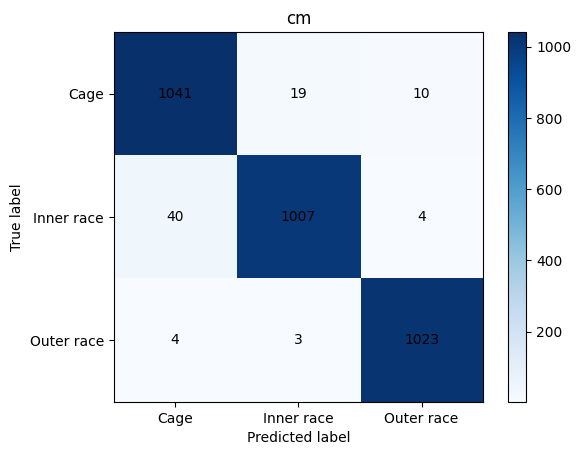

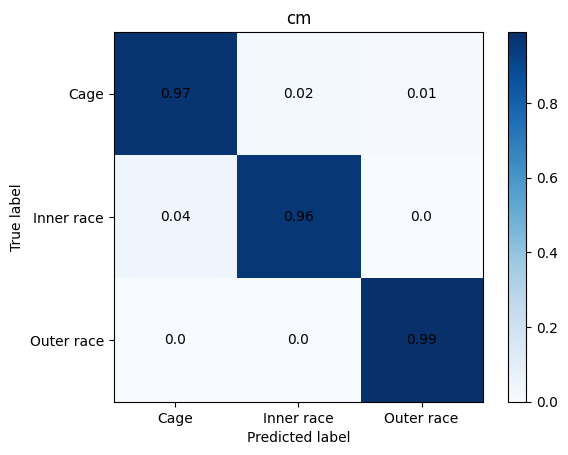

In [27]:
all_labels,all_preds = all_labels.cpu(),all_preds.cpu()

conf_matrix = confusion_matrix(all_labels, all_preds)

plot_confusion_matrix(conf_matrix,['Cage', 'Inner race', 'Outer race'],title='cm',is_norm=False)
plot_confusion_matrix(conf_matrix,['Cage', 'Inner race', 'Outer race'],title='cm',is_norm=True)